In [20]:
import scipy.io as sio
import os

from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import time
from pathlib import Path

# Load anno_bbox.mat

In [2]:
HOME_DIR = str(Path.home())
data_path = os.path.join(HOME_DIR, "projectdata/cht01/hico_20160224_det")
data_path

'/home/jovyan/projectdata/cht01/hico_20160224_det'

In [3]:
anno_bbox = sio.loadmat(data_path + '/anno_bbox.mat', squeeze_me=True)

In [4]:
bbox_train = anno_bbox['bbox_train']
bbox_test = anno_bbox['bbox_test']

# Explore data

In [5]:
i = 1
print(bbox_train[i]['filename'])
print(bbox_train[i]['size'])
print(bbox_train[i]['hoi'])

HICO_train2015_00000002.jpg
(640, 480, 3)
(224, array((262, 638, 1, 138), 
      dtype=[('x1', 'O'), ('x2', 'O'), ('y1', 'O'), ('y2', 'O')]), array((162, 258, 131, 165), 
      dtype=[('x1', 'O'), ('x2', 'O'), ('y1', 'O'), ('y2', 'O')]), array([1, 1], dtype=int32), 0)


In [6]:
bbox_train[0]['hoi']

array([ (153, array((208, 427, 33, 300), 
      dtype=[('x1', 'O'), ('x2', 'O'), ('y1', 'O'), ('y2', 'O')]), array((59, 572, 98, 405), 
      dtype=[('x1', 'O'), ('x2', 'O'), ('y1', 'O'), ('y2', 'O')]), array([1, 1], dtype=int32), 0),
       (154, array((213, 438, 20, 357), 
      dtype=[('x1', 'O'), ('x2', 'O'), ('y1', 'O'), ('y2', 'O')]), array((77, 583, 115, 396), 
      dtype=[('x1', 'O'), ('x2', 'O'), ('y1', 'O'), ('y2', 'O')]), array([1, 1], dtype=int32), 0),
       (155, array((206, 427, 33, 306), 
      dtype=[('x1', 'O'), ('x2', 'O'), ('y1', 'O'), ('y2', 'O')]), array((61, 571, 100, 401), 
      dtype=[('x1', 'O'), ('x2', 'O'), ('y1', 'O'), ('y2', 'O')]), array([1, 1], dtype=int32), 0),
       (156, array((209, 444, 26, 317), 
      dtype=[('x1', 'O'), ('x2', 'O'), ('y1', 'O'), ('y2', 'O')]), array((59, 579, 99, 395), 
      dtype=[('x1', 'O'), ('x2', 'O'), ('y1', 'O'), ('y2', 'O')]), array([1, 1], dtype=int32), 0)], 
      dtype=[('id', 'O'), ('bboxhuman', 'O'), ('bboxobject'

In [7]:
bbox_train[0]['hoi'][0]['bboxhuman']

array((208, 427, 33, 300), 
      dtype=[('x1', 'O'), ('x2', 'O'), ('y1', 'O'), ('y2', 'O')])

In [8]:
bbox_train[1]['hoi']

array((224, array((262, 638, 1, 138), 
      dtype=[('x1', 'O'), ('x2', 'O'), ('y1', 'O'), ('y2', 'O')]), array((162, 258, 131, 165), 
      dtype=[('x1', 'O'), ('x2', 'O'), ('y1', 'O'), ('y2', 'O')]), array([1, 1], dtype=int32), 0), 
      dtype=[('id', 'O'), ('bboxhuman', 'O'), ('bboxobject', 'O'), ('connection', 'O'), ('invis', 'O')])

In [9]:
bbox_train[1]['hoi'][np.newaxis][0]['bboxhuman']

array((262, 638, 1, 138), 
      dtype=[('x1', 'O'), ('x2', 'O'), ('y1', 'O'), ('y2', 'O')])

In [10]:
len(bbox_train[8]['hoi'][np.newaxis][0]['connection'][0])

2

In [11]:
bbox_train[1]

('HICO_train2015_00000002.jpg', array((640, 480, 3), 
      dtype=[('width', 'O'), ('height', 'O'), ('depth', 'O')]), array((224, array((262, 638, 1, 138), 
      dtype=[('x1', 'O'), ('x2', 'O'), ('y1', 'O'), ('y2', 'O')]), array((162, 258, 131, 165), 
      dtype=[('x1', 'O'), ('x2', 'O'), ('y1', 'O'), ('y2', 'O')]), array([1, 1], dtype=int32), 0), 
      dtype=[('id', 'O'), ('bboxhuman', 'O'), ('bboxobject', 'O'), ('connection', 'O'), ('invis', 'O')]))

# Define dataframe transformer

In [12]:
def ToDataframe(mat_data):
    bbox_data = mat_data.copy()

    img_names = []
    img_sizes = []
    img_hoi_human_bbox = []
    img_hoi_obj_bbox = []
    img_hoi_act = []

    fail_img = []

    for data_id in range(len(bbox_data)):    
        bbox = bbox_data[data_id]

        img_name = bbox['filename']

        img_size = [int(bbox['size']['width']),
                    int(bbox['size']['height']),
                    int(bbox['size']['depth'])]

        bbox_hois = bbox['hoi']
        if(bbox_hois.ndim == 0):
            bbox_hois = bbox_hois[np.newaxis]

        img_hoi = []
        # for each HOI type
        for hoi_id in range(len(bbox_hois)): 
            bbox_hoi = bbox_hois[hoi_id]

            action = bbox_hoi['id']
            invis = bbox_hoi['invis']

            # unify format
            if(bbox_hoi['connection'].ndim == 1) : 
                bbox_hoi['connection'] = bbox_hoi['connection'][np.newaxis]
            if(bbox_hoi['bboxhuman'].ndim == 0) : 
                bbox_hoi['bboxhuman'] = bbox_hoi['bboxhuman'][np.newaxis]
            if(bbox_hoi['bboxobject'].ndim == 0) : 
                bbox_hoi['bboxobject'] = bbox_hoi['bboxobject'][np.newaxis]

            # for each connection, get human bbox and object bbox
            for con_id in range(len(bbox_hoi['connection'])):
                if(len(bbox_hoi['connection'][con_id]) < 2):
                    continue
                human_bbox_id = bbox_hoi['connection'][con_id][0] - 1
                obj_bbox_id = bbox_hoi['connection'][con_id][1] - 1

                human_bbox = bbox_hoi['bboxhuman'][human_bbox_id]
                obj_bbox = bbox_hoi['bboxobject'][obj_bbox_id]

                human_bbox = [int(human_bbox['x1']),
                             int(human_bbox['x2']),
                             int(human_bbox['y1']),
                             int(human_bbox['y2'])]

                obj_bbox = [int(obj_bbox['x1']),
                             int(obj_bbox['x2']),
                             int(obj_bbox['y1']),
                             int(obj_bbox['y2'])]

                img_names.append(img_name)
                img_sizes.append(img_size)
                img_hoi_human_bbox.append(human_bbox)
                img_hoi_obj_bbox.append(obj_bbox)
                img_hoi_act.append(action)

    dataFrame = pd.DataFrame({
        'name':img_names,
        'action_no':img_hoi_act,
        'human_bbox':img_hoi_human_bbox,
        'obj_bbox':img_hoi_obj_bbox,
        'img_size_w_h':img_sizes
    })
    
    return dataFrame

In [13]:
img_hoi_train = ToDataframe(bbox_train)
img_hoi_test = ToDataframe(bbox_test)

In [16]:
img_hoi_train.head()

,action_no,human_bbox,img_size_w_h,name,obj_bbox
0,153,"[208, 427, 33, 300]","[640, 480, 3]",HICO_train2015_00000001.jpg,"[59, 572, 98, 405]"
1,154,"[213, 438, 20, 357]","[640, 480, 3]",HICO_train2015_00000001.jpg,"[77, 583, 115, 396]"
2,155,"[206, 427, 33, 306]","[640, 480, 3]",HICO_train2015_00000001.jpg,"[61, 571, 100, 401]"
3,156,"[209, 444, 26, 317]","[640, 480, 3]",HICO_train2015_00000001.jpg,"[59, 579, 99, 395]"
4,224,"[262, 638, 1, 138]","[640, 480, 3]",HICO_train2015_00000002.jpg,"[162, 258, 131, 165]"


In [15]:
print(img_hoi_train.shape)
print(img_hoi_test.shape)

(117871, 5)
(33405, 5)


# Save to CSV file

In [17]:
img_hoi_train.to_csv('anno_box_train.csv')
img_hoi_test.to_csv('anno_box_test.csv')

# Load from CSV file

In [21]:
img_hoi_train = pd.DataFrame.from_csv('anno_box_train.csv')
img_hoi_train['human_bbox'] = img_hoi_train['human_bbox'].apply(lambda x: list(map(int,x.strip('[]').split(',')))) # str to tuple
img_hoi_train['obj_bbox'] = img_hoi_train['obj_bbox'].apply(lambda x: list(map(int,x.strip('[]').split(',')))) # str to tuple

In [22]:
img_hoi_test = pd.DataFrame.from_csv('anno_box_test.csv')
img_hoi_test['human_bbox'] = img_hoi_test['human_bbox'].apply(lambda x: list(map(int,x.strip('[]').split(',')))) # str to tuple
img_hoi_test['obj_bbox'] = img_hoi_test['obj_bbox'].apply(lambda x: list(map(int,x.strip('[]').split(',')))) # str to tuple

# Load action ID lookup table

In [23]:
action_list = pd.read_csv('action_list.csv')
action_list.head()

,id,object,verb
0,1,airplane,board
1,2,airplane,direct
2,3,airplane,exit
3,4,airplane,fly
4,5,airplane,inspect


# Visualize HOI bbox

In [24]:
def DrawImgWithBBox(rgb_img, human_bbox, obj_bbox, title=None, img_size=(5,5)):
    cv2.rectangle(RGB_img, 
                  (human_bbox[0], human_bbox[2]), 
                  (human_bbox[1], human_bbox[3]), 
                  (0,0,255), 2)

    cv2.rectangle(RGB_img, 
                  (obj_bbox[0], obj_bbox[2]), 
                  (obj_bbox[1], obj_bbox[3]), 
                  (0,255,0), 2)

    fig = plt.figure(figsize=img_size)
    if(title != None):
        plt.title(title)
    plt.imshow(RGB_img)
    plt.show()

## Draw images

HICO_train2015_00000001.jpg


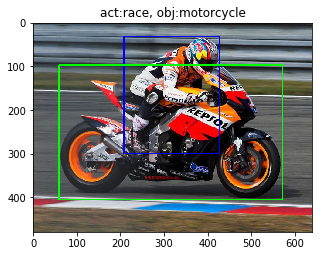

HICO_train2015_00000001.jpg


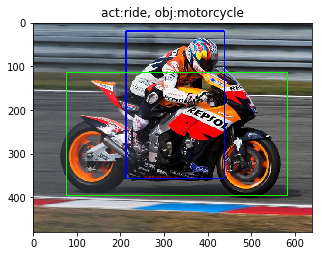

HICO_train2015_00000001.jpg


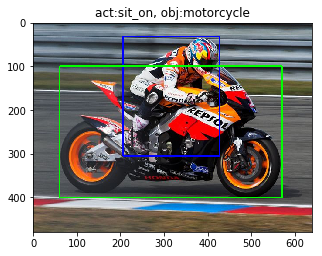

HICO_train2015_00000001.jpg


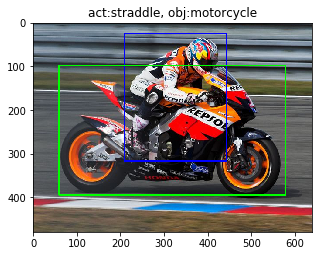

HICO_train2015_00000002.jpg


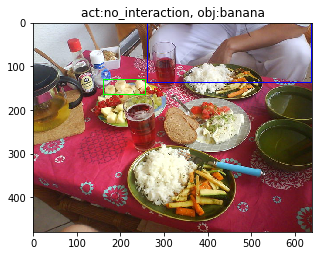

HICO_train2015_00000003.jpg


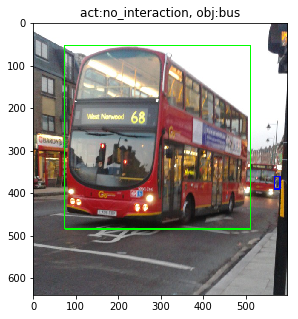

HICO_train2015_00000004.jpg


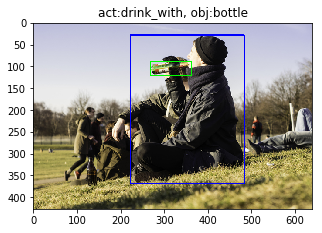

HICO_train2015_00000004.jpg


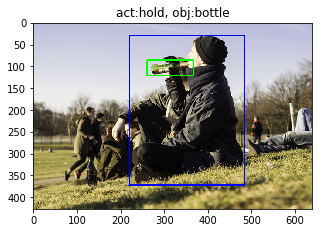

HICO_train2015_00000005.jpg


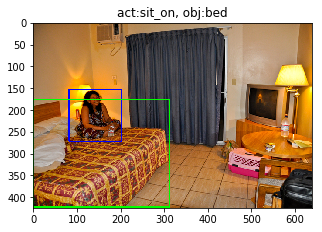

HICO_train2015_00000006.jpg


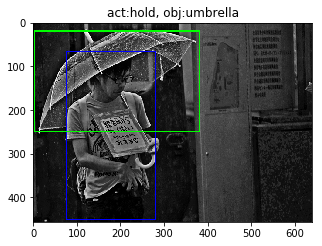

HICO_train2015_00000006.jpg


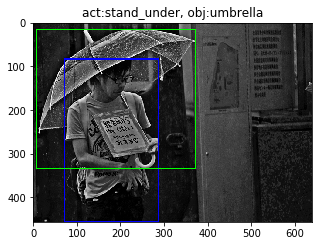

HICO_train2015_00000007.jpg


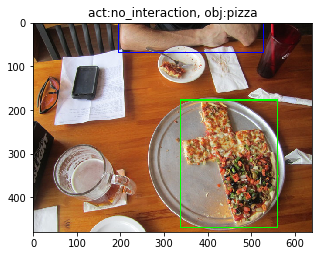

HICO_train2015_00000008.jpg


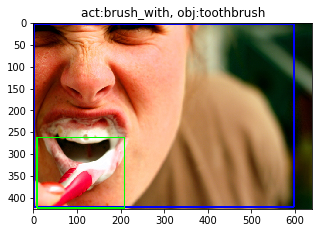

HICO_train2015_00000008.jpg


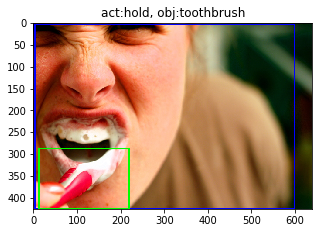

HICO_train2015_00000009.jpg


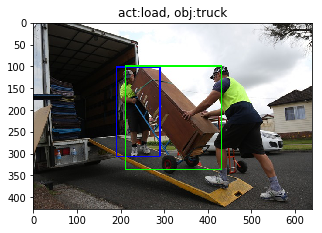

HICO_train2015_00000009.jpg


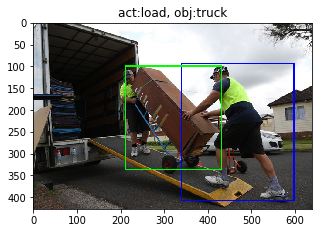

HICO_train2015_00000010.jpg


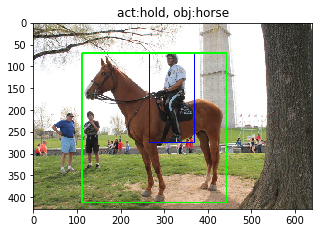

HICO_train2015_00000010.jpg


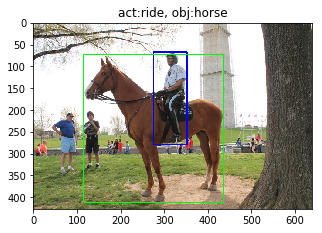

HICO_train2015_00000010.jpg


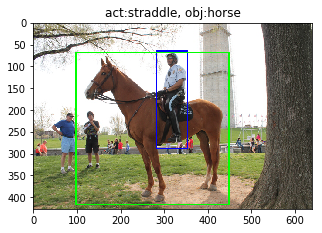

HICO_train2015_00000011.jpg


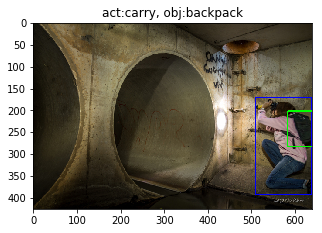

In [26]:
for i in range(20):
    img_hoi = img_hoi_train.iloc[i]

    print(img_hoi['name'])
    input_img = cv2.imread(data_path + '/images/train2015/' + img_hoi['name'])
    RGB_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

    human_bbox = img_hoi['human_bbox']
    obj_bbox = img_hoi['obj_bbox']
    
    action = action_list[action_list['id'] == img_hoi['action_no']].iloc[0]
    
    DrawImgWithBBox(RGB_img, 
                    human_bbox, 
                    obj_bbox, 
                    'act:{}, obj:{}'.format(action['verb'], action['object']),
                   (5,5))

# Visualize by image name

In [35]:
img_name = 'HICO_train2015_00038149.jpg'
img_hoi = img_hoi_train[img_hoi_train['name'] == img_name].iloc[0]

In [36]:
input_img = cv2.imread(data_path + '/images/train2015/' + img_hoi['name'])
RGB_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

In [37]:
RGB_img.shape

(640, 477, 3)

## Draw

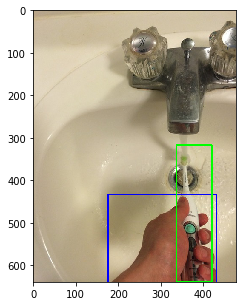

In [38]:
human_bbox = img_hoi['human_bbox']
obj_bbox = img_hoi['obj_bbox']

DrawImgWithBBox(RGB_img, human_bbox, obj_bbox)

## Rotate image

In [33]:
RGB_img = np.rot90(RGB_img, -1)
RGB_img = RGB_img.copy() # OpenCV issue

In [34]:
RGB_img.shape

(640, 427, 3)